<a href="https://colab.research.google.com/github/KellieLeonard-Biostat/LSTM-EMG/blob/main/EMG_LSTM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget -r -N -c -np https://physionet.org/files/tpehgdb/1.0.1/ -P /content/data


Streaming output truncated to the last 5000 lines.
Length: 846240 (826K) [application/octet-stream]
Saving to: ‘/content/data/physionet.org/files/tpehgdb/1.0.1/tpehgdb/tpehg1226.dat’

physionet.org/files 100%[===================>] 826.41K   546KB/s    in 1.5s    

2025-07-06 10:26:38 (546 KB/s) - ‘/content/data/physionet.org/files/tpehgdb/1.0.1/tpehgdb/tpehg1226.dat’ saved [846240/846240]

--2025-07-06 10:26:38--  https://physionet.org/files/tpehgdb/1.0.1/tpehgdb/tpehg1226.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1014 [text/plain]
Saving to: ‘/content/data/physionet.org/files/tpehgdb/1.0.1/tpehgdb/tpehg1226.hea’

physionet.org/files 100%[===================>]    1014  --.-KB/s    in 0s      

2025-07-06 10:26:38 (1015 MB/s) - ‘/content/data/physionet.org/files/tpehgdb/1.0.1/tpehgdb/tpehg1226.hea’ saved [1014/1014]

--2025-07-06 10:26:38--  https://physionet.org/files/tpehgdb/1.0.1/tpehgdb/tpehg1228.dat
Reusing existing

In [3]:
!pip install wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 133.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [4]:
import os
import wfdb
import numpy as np

def parse_gestation_label(hea_file):
    """
    Parse gestational age from .hea file and assign label:
    - 0 = term (gestation >= 37 weeks)
    - 1 = preterm (gestation < 37 weeks)
    """
    with open(hea_file, 'r') as f:
        for line in f:
            if line.startswith('#    Gestation'):
                gest_week = float(line.split()[-1])
                label = 0 if gest_week >= 37 else 1
                return label
    return -1  # label not found

def load_data_with_labels(data_dir):
    """
    Load all .dat files and their labels from .hea gestation info.
    Returns:
        X: list of numpy arrays (signals)
        y: list of int (labels)
    """
    X = []
    y = []
    for file in os.listdir(data_dir):
        if file.endswith('.dat'):
            record_name = file[:-4]
            dat_path = os.path.join(data_dir, record_name)
            hea_path = os.path.join(data_dir, record_name + '.hea')

            label = parse_gestation_label(hea_path)
            if label == -1:
                print(f"Gestation label not found for {record_name}, skipping")
                continue

            try:
                record = wfdb.rdrecord(dat_path)
                # Extract first channel (assuming contractions)
                signal = record.p_signal[:, 0]
                X.append(signal)
                y.append(label)
            except Exception as e:
                print(f"Error loading {record_name}: {e}")
    return X, y

# Set your local dataset folder path here
data_dir = '/content/data/physionet.org/files/tpehgdb/1.0.1/tpehgdb'

# Load data and labels
X, y = load_data_with_labels(data_dir)

print(f"Loaded {len(X)} samples")
print(f"Labels distribution: Term={sum(i == 0 for i in y)}, Preterm={sum(i == 1 for i in y)}")

# Example: print shape of first signal
if len(X) > 0:
    print(f"Example signal shape: {X[0].shape}")


Loaded 300 samples
Labels distribution: Term=262, Preterm=38
Example signal shape: (35180,)


In [5]:
import numpy as np

def preprocess_signals(X, max_len=35000):
    X_processed = []
    for sig in X:
        # Normalize (z-score)
        sig = (sig - np.mean(sig)) / np.std(sig)

        # Pad or truncate
        if len(sig) < max_len:
            pad_width = max_len - len(sig)
            sig = np.pad(sig, (0, pad_width), mode='constant')
        else:
            sig = sig[:max_len]
        X_processed.append(sig)
    return np.array(X_processed)


In [6]:
from sklearn.model_selection import train_test_split

X_proc = preprocess_signals(X)
y_np = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y_np, test_size=0.2, random_state=42, stratify=y_np)

# Reshape for LSTM: (samples, timesteps, features)
# Our feature dimension is 1 (single signal per timestep)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (240, 35000, 1), Test shape: (60, 35000, 1)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 35000, 64)      │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 35000, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 35000, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,729 (116.13 KB)

 Trainable params: 29,537 (115.38 KB)

 Non-trainable params: 192 (768.00 B)

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16
)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7179 - loss: 0.6010 - val_accuracy: 0.8667 - val_loss: 0.5099
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6866 - loss: 0.6395 - val_accuracy: 0.8667 - val_loss: 0.5036
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7062 - loss: 0.6149 - val_accuracy: 0.8667 - val_loss: 0.4863
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7942 - loss: 0.5155 - val_accuracy: 0.8667 - val_loss: 0.4722
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7306 - loss: 0.5288 - val_accuracy: 0.8667 - val_loss: 0.4700
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7584 - loss: 0.5667 - val_accuracy: 0.8667 - val_loss: 0.4600
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8065 - loss: 0.4994 - val_accuracy: 0.8667 - val_loss: 0.4579
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7944 - loss: 0.4794 - val_accuracy: 0.8667 - val_loss:

In [12]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step - accuracy: 0.8486 - loss: 0.4238
Test Accuracy: 0.867


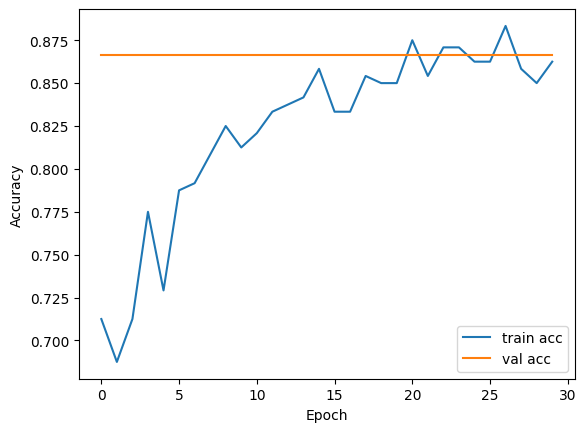

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [1]:
# Preprocess all signals
X_processed = preprocess_signals(X, max_len=35000)

# Split by label
X_preterm = X_processed[np.array(y) == 1]
X_term = X_processed[np.array(y) == 0]

# Mean signals
mean_preterm = np.mean(X_preterm, axis=0)
mean_term = np.mean(X_term, axis=0)

# Plot mean signals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(mean_preterm, label='Preterm', alpha=0.8)
plt.plot(mean_term, label='Full term', alpha=0.8)
plt.xlabel('Time (samples)')
plt.ylabel('Normalized amplitude')
plt.title('Mean EMG signals after preprocessing')
plt.legend()
plt.show()


NameError: name 'preprocess_signals' is not defined

/tmp/ipython-input-16-1448836390.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([preterm_std, term_std], labels=['Preterm', 'Full term'])


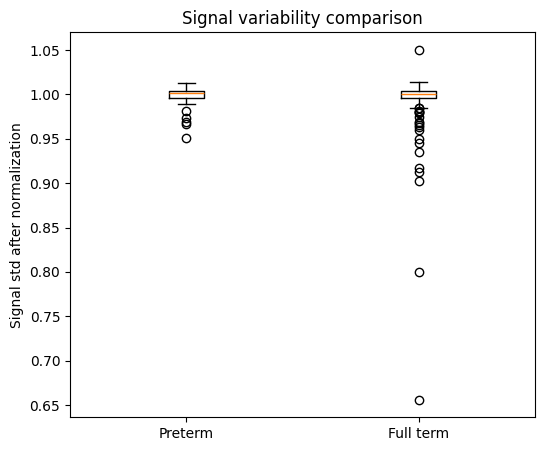

In [16]:
preterm_std = np.std(X_preterm, axis=1)
term_std = np.std(X_term, axis=1)

plt.figure(figsize=(6, 5))
plt.boxplot([preterm_std, term_std], labels=['Preterm', 'Full term'])
plt.ylabel('Signal std after normalization')
plt.title('Signal variability comparison')
plt.show()
